# Analysis of Appendix B.3.1

In [34]:
library(ggplot2)
library(data.table)
library(BBmisc)
library(mlr)
library(smoof)

library(GGally)

library(ggpubr)

theme_set(theme_pubr())
source("helper.r")

Warning message:
"package 'smoof' was built under R version 3.6.3"Loading required package: checkmate
Warning message:
"package 'checkmate' was built under R version 3.6.3"

In [2]:
# set path and dimensions to extract
savepath = file.path("..", "data", "runs", "synthetic_enhanced_eval")
dim = c(3, 5, 8)
runs = paste0("StyblinskiTang", dim, "D")


[1] "StyblinskiTang3D"

### Create PDP plots for x1 and iteration 1 

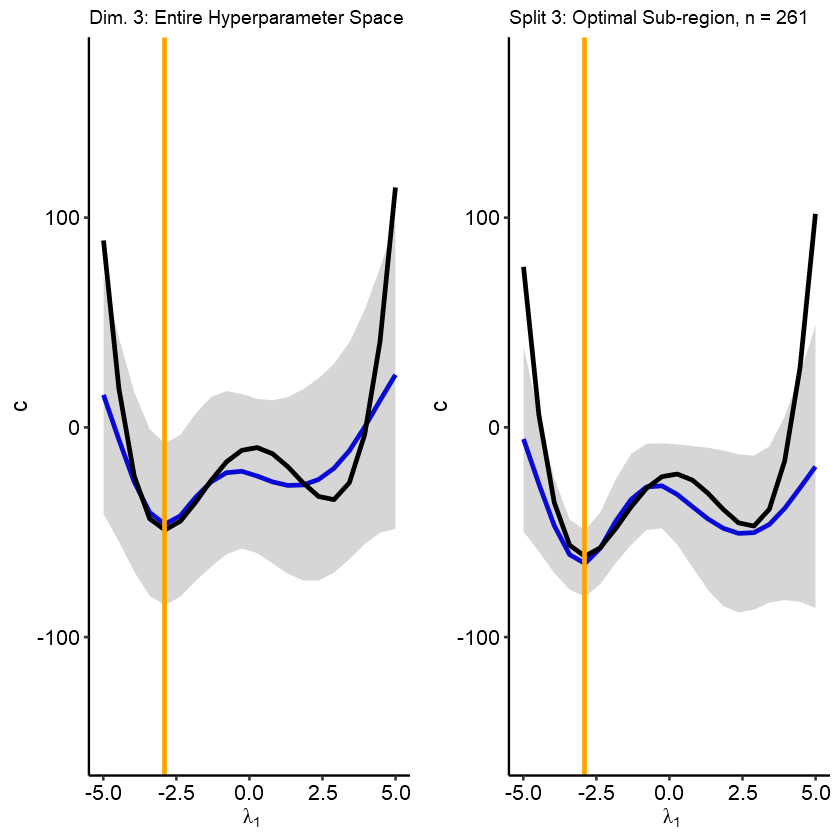

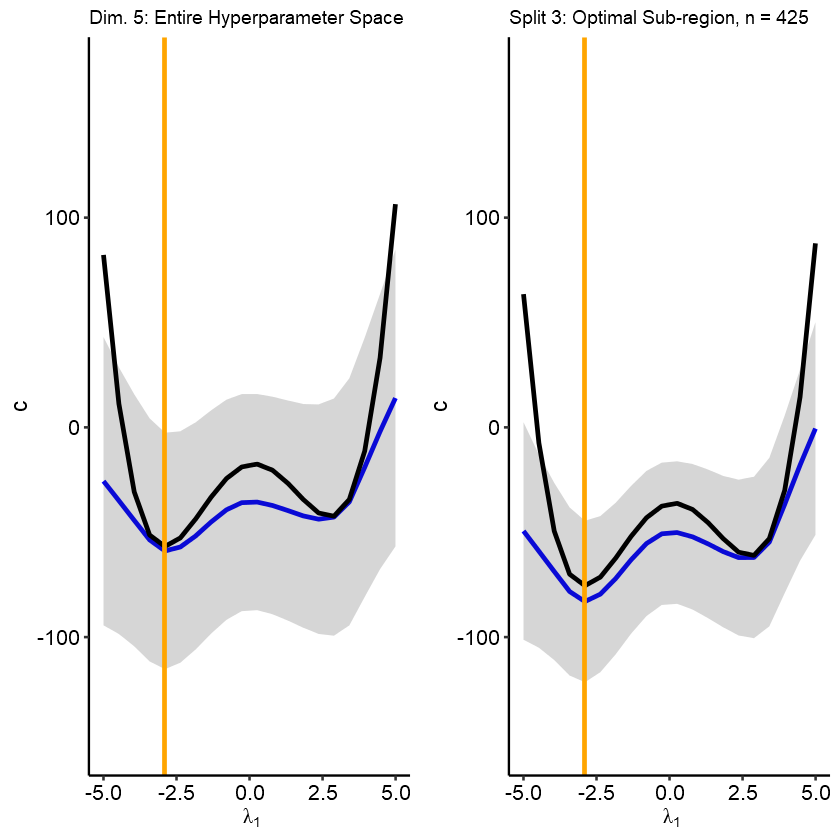

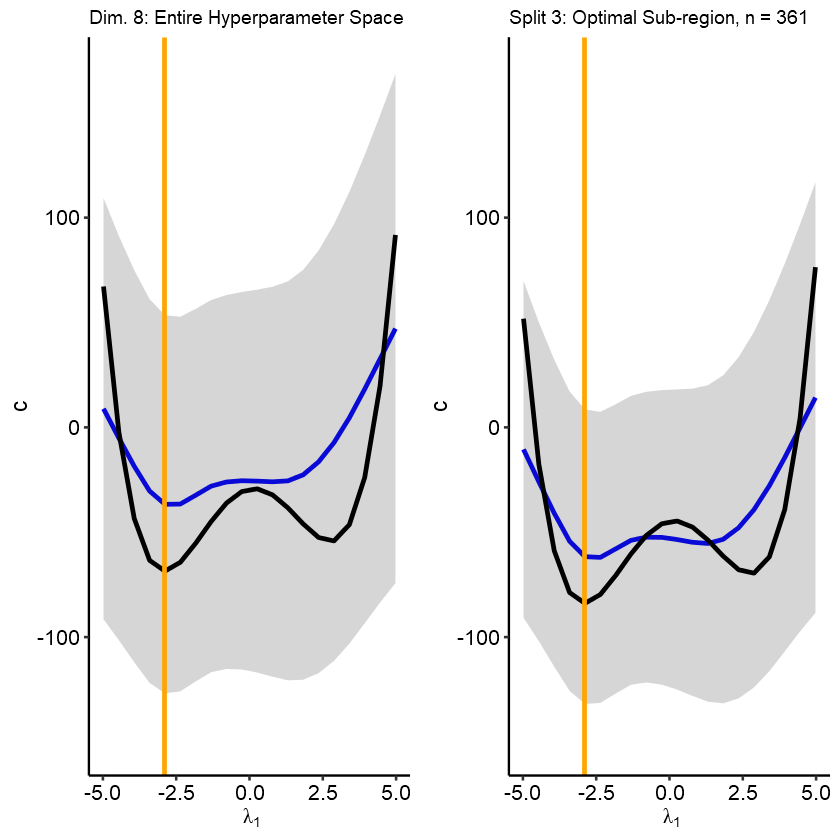

In [43]:
plots = lapply(1:length(runs), function(i){
    # extract data and determine optimum
    data.all  = readRDS(paste0(savepath, "/", runs[i], "/eval_SS_L2.rds"))
    features  = names(data.all$result[[1]]$opt.path)[1:dim[i]]
    traindata = data.all$result[[1]]$opt.path
    optimum   = traindata[which.min(traindata$y), features]
    iter      = 1
    
    # Calculate PDP and confidence estimates for hyperparameter x_1
    feat = "x1"

    # calculate global PDP and confidence bands
    data = data.all$result[[1]]$reslist[[iter]][[feat]]
    data.pdp = data$res.pdp
    data.pdp$lower = data.pdp$mean - data.pdp$sd*1.96
    data.pdp$upper = data.pdp$mean + data.pdp$sd*1.96

    # Extract ICE curves
    data.ice = data$res.ice

    # Extract tree and split criteria for optimal subregions after 3 splits
    tree = data$trees[[1]][1:4]
    split.criteria = find_split_criteria(tree, optimum)
    split.criteria$values = round(split.criteria$values, 4)

    # Create true PDP and ICE estimates
    dimension = dim[i]
    id = "StyblinskiTang"
    # objective function
    obj = makeSingleObjectiveFunction(name = paste0(id, dimension, "D"), fn = function(x) {
            1 / 2 * sum(x^4 - 16 * x^2 + 5 * x)
        }, 
        par.set = makeParamSet(makeNumericVectorParam(id = "x", len = dimension, lower = - 5, upper = 5)), 
        global.opt.params = rep(-2.9035, dimension)
    )
    # create testdata 
    set.seed(123456)
    testdata = generateRandomDesign(n = 1000, par.set = getParamSet(obj))
    
    # calculate true ICE and global PDP estimates
    data.ice = cbind(data.ice, do.call("rbind", replicate(20, testdata[,-which(colnames(testdata)==feat)], simplify = FALSE)))
    data.ice$gt = apply(as.data.frame(data.ice)[,features], 1, obj)
    gt.pdp = data.ice %>% group_by(get(feat)) %>% summarise(mean.opt = mean(gt))
    colnames(gt.pdp) = c(feat, "mean")
    

    # Calculate PDP and confidence estimates for optimal subregion after 3 splits
    optimal.node = find_optimal_node(tree, optimum)
    ind.opt = optimal.node$subset.idx
    pdp.opt = data.ice[data.ice$.id %in% ind.opt,] %>% group_by(get(feat)) %>% summarise(mean.opt = mean(mean), sd.opt = mean(sd))
    pdp.opt$lower = pdp.opt$mean.opt - pdp.opt$sd.opt*1.96
    pdp.opt$upper = pdp.opt$mean.opt + pdp.opt$sd.opt*1.96
    colnames(pdp.opt) = c(feat, "mean", "sd",   "lower" , "upper")
    gt.opt = data.ice[data.ice$.id %in% ind.opt,] %>% group_by(get(feat)) %>% summarise(mean.opt = mean(gt))
    colnames(gt.opt) = c(feat, "mean")
    
    y_lim = c(-150, 170)

    # Global PDP with confidence bands
    p.pdp = ggplot(data = data.pdp, aes_string(x = feat, y = "mean")) + 
      geom_line(colour = "blue", lwd = 1) + 
      geom_ribbon(aes(ymin = lower, ymax = upper), alpha = 0.2) + 
      geom_line(data = gt.pdp, lwd = 1) +
      geom_vline(aes(xintercept = as.numeric(optimum[feat])), colour = "orange", lwd = 1) +
      ylim(y_lim) + ylab("c") + xlab(~lambda[1]) +
      labs(title = paste0("Dim. ", dim[i], ": Entire Hyperparameter Space")) +
      theme(plot.title = element_text(size = 11),
            axis.title.y = element_text(size = 14))

    # Sub-regional PDP with confidence bands
    p.pdp.opt = ggplot(data = pdp.opt, aes_string(x = feat, y = "mean")) + 
      geom_line(colour = "blue", lwd = 1) + 
      geom_ribbon(aes(ymin = lower, ymax = upper), alpha = 0.2) + 
      geom_line(data = gt.opt, lwd = 1) +
      geom_vline(aes(xintercept = as.numeric(optimum[feat])), colour = "orange", lwd = 1) +
      ylim(y_lim) + ylab("c")  + xlab(~lambda[1]) +
      labs(title = paste0("Split 3: Optimal Sub-region, n = ", length(ind.opt))) +
      theme(plot.title = element_text(size = 11),
            axis.title.y = element_text(size = 14))


    p1 = gridExtra::grid.arrange(p.pdp, p.pdp.opt, nrow = 1)
    p1
})

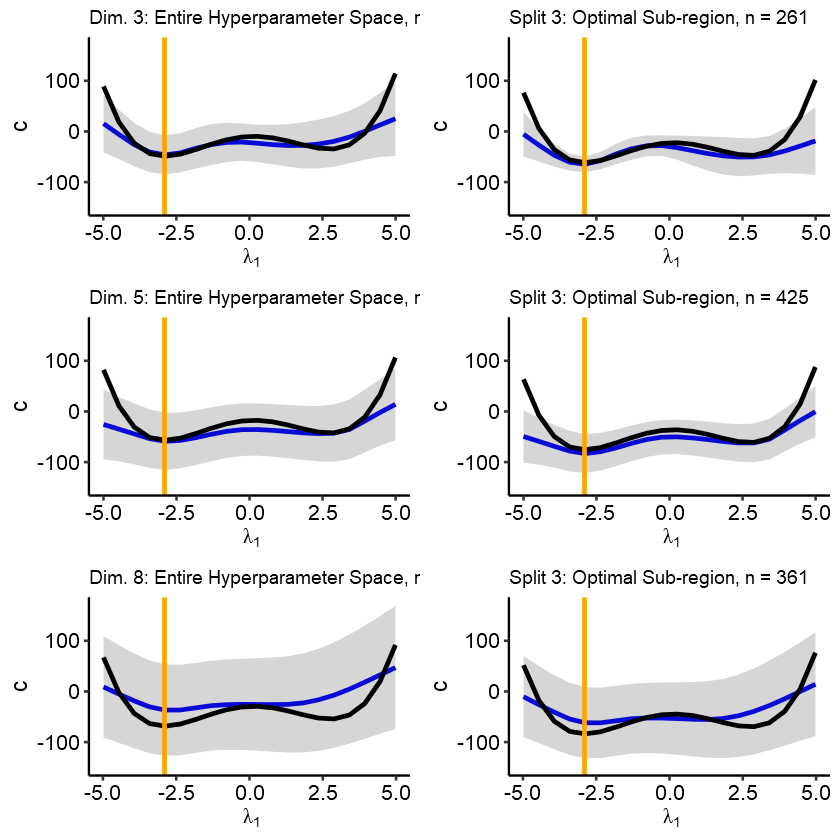

In [40]:
gridExtra::grid.arrange(plots[[1]], plots[[2]], plots[[3]], nrow = 3)

In [47]:
ggsave("pdp_synthetic.png", gridExtra::grid.arrange(plots[[1]], plots[[2]], plots[[3]], nrow = 3), width = 7, height = 7)